## use the fits file downloaded

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
import numpy.matlib 
path_notebooks = os.path.abspath('.')
path_data = join(os.path.split(path_notebooks)[0], '/root/cosmos/galaxies-mzr/data')
from marvin.tools import Maps 
filename = join(path_data, 'manga-8077-6104-MAPS-HYB10-GAU-MILESHC.fits.gz')
maps = Maps(filename=filename)
nii = maps.emline_gflux_nii_6585
ha = maps.emline_gflux_ha_6564
#nii_la=nii.value
#ha_la=ha.value
#n2_la=nii_la(nii_la!=0)/ha_la(ha_la!=0)
#print(n2_la)
#lala=np.matlib.zeros(ha.shape, dtype =  float)


## use data from remote server 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from marvin.tools import Maps 
maps = Maps('8077-6104')
nii = maps.emline_gflux_nii_6585
ha = maps.emline_gflux_ha_6564

In [20]:
n2 = nii / ha
logn2 = np.log10(n2)

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value


## test the bug

In [5]:
print(type(logn2))

<class 'marvin.tools.quantities.map.EnhancedMap'>


In [118]:
y = logn2 * 0.57
z=   y+8.9

In [119]:
print(type(y))
print(type(z))

<class 'marvin.tools.quantities.map.EnhancedMap'>
<class 'marvin.tools.quantities.map.EnhancedMap'>


In [120]:
marvin.tools.quantities.map.EnhancedMap?

## here is the problem

In [6]:
lala=np.ones(ha.shape, dtype =  float)
#oh=0.57*logn2+lala*8.90
oh=(8.90*lala)+(0.57*logn2)

NotImplementedError: np.add is not implemented for EnhancedMap.

## if switch the two parts, it will success

In [7]:
lala=np.ones(ha.value.shape, dtype =  float)
oh =  (0.57*logn2)+(8.90*lala)

In [8]:
oh=(8.90*lala)+(0.57*logn2.value)

In [13]:
np.sum(oh[np.where(oh>0)])

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


11295.004199765563

In [21]:
oh =  (0.57*logn2)+8.90

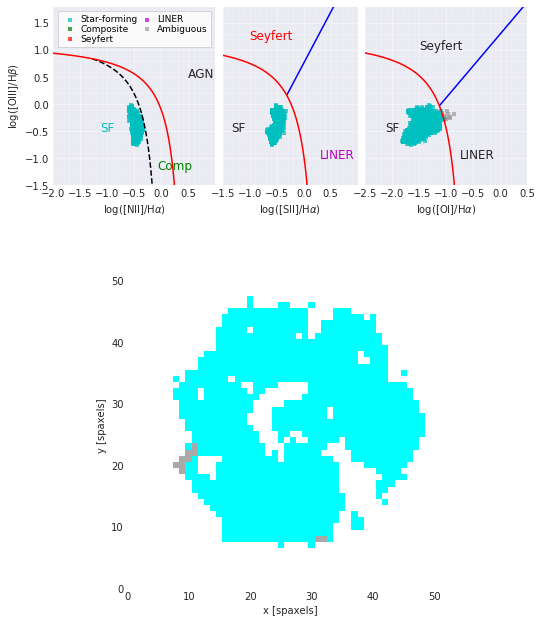

In [22]:
masks_bpt, __, __ = maps.get_bpt()

In [37]:
masks_bpt['sf']['global']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [38]:
n2.pixmask.schema

,bit,label,description
0,0,NOCOV,No coverage in this spaxel
1,1,LOWCOV,Low coverage in this spaxel
2,2,DEADFIBER,Major contributing fiber is dead
3,3,FORESTAR,Foreground star
4,4,NOVALUE,Spaxel was not fit because it did not meet sel...
5,5,UNRELIABLE,Value is deemed unreliable; see TRM for defini...
6,6,MATHERROR,Mathematical error in computing value
7,7,FITFAILED,Attempted fit for property failed
8,8,NEARBOUND,Fitted value is too near an imposed boundary; ...
9,9,NOCORRECTION,Appropriate correction not available


In [23]:
mask_non_sf = ~masks_bpt['sf']['global'] * n2.pixmask.labels_to_value('DONOTUSE')

In [24]:
mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])

In [25]:
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

In [26]:
mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr

/root/anaconda3/lib/python3.7/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True


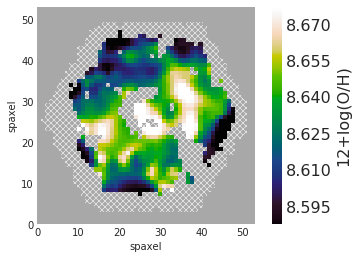

In [27]:
fig, ax = oh.plot(mask=mask, cblabel='12+log(O/H)')

In [31]:
import pandas as pd
mstar = pd.read_csv(join(path_data, 'manga-{}_mstar.csv'.format(maps.plateifu)))

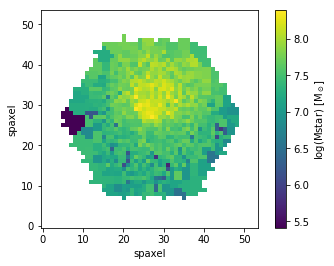

In [32]:
fig, ax = plt.subplots()
p = ax.imshow(mstar, origin='lower')
ax.set_xlabel('spaxel')
ax.set_ylabel('spaxel')
cb = fig.colorbar(p)
cb.set_label('log(Mstar) [M$_\odot$]')

In [34]:
spaxel_size = 0.5  # [arcsec]

# or programmatically:
# spaxel_size = float(maps.getCube().header['CD2_2']) * 3600

In [39]:
redshift = maps.nsa['z']

TypeError: 'NoneType' object is not subscriptable

In [36]:
c = 299792  # speed of light [km/s]
H0 = 70  # [km s^-1 Mpc^-1]
D = c * redshift / H0  # approx. distance to galaxy [Mpc]

NameError: name 'redshift' is not defined

In [50]:
scale = 1 / 206265 * D * 1e6  # 1 radian = 206265 arcsec [pc / arcsec]

In [51]:
spaxel_area = (scale * spaxel_size)**2  # [pc^2]

In [52]:
sigma_star = np.log10(10**mstar / spaxel_area)  # [Msun / pc^2]

NameError: name 'sigma_star' is not defined

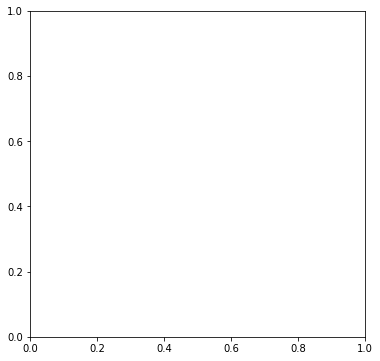

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(sigma_star.values[mask == 0], oh.value[mask == 0], alpha=0.15)
ax.set_xlabel('log(Mstar) [M$_\odot$]')
ax.set_ylabel('12+log(O/H)')
ax.axis([0, 4, 8.0, 8.8])

In [54]:
# fitting formula
aa = 8.55
bb = 0.014
cc = 3.14
xx = np.linspace(1, 3, 1000)
yy = aa + bb * (xx - cc) * np.exp(-(xx - cc))

[0, 4, 8.0, 8.8]

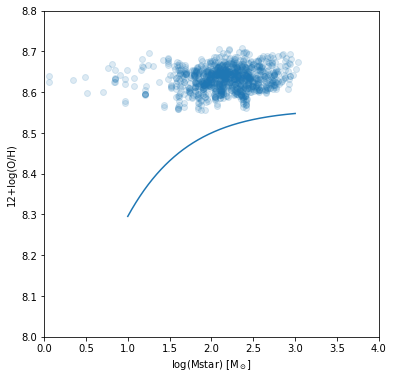

In [55]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(sigma_star.values[mask == 0], oh.value[mask == 0], alpha=0.15)
ax.plot(xx, yy)
ax.set_xlabel('log(Mstar) [M$_\odot$]')
ax.set_ylabel('12+log(O/H)')
ax.axis([0, 4, 8.0, 8.8])

### 使用论文中的 [O II]/[N II] ratio.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from os.path import join
path_notebooks = os.path.abspath('.')
path_data = join(os.path.split(path_notebooks)[0], '/root/cosmos/galaxies-mzr/data')

In [41]:
from marvin.tools.maps import Maps
filename = join(path_data, 'manga-8077-6104-MAPS-HYB10-GAU-MILESHC.fits.gz')
maps = Maps(filename=filename)
#maps = Maps('8252-9102')

In [3]:
#失败失败失败
#直接使用Marvin读取fits文件
#测试导入fits格式文件，提取各个元素的flux
from marvin.tools.maps import Maps
filename = join(path_data, 'manga_firefly-v2_4_3-STELLARPOP.fits')
maps = Maps(filename=filename)
#maps = Maps('8252-9102')

INFO: No release version set. Setting default to DR15


KeyError: "Keyword 'MANGAID' not found."

In [ ]:
maps.emline

In [76]:
nii = maps.emline_gflux_nii_6585
ha = maps.emline_gflux_ha_6564
oii7=maps.emline_gflux_oii_3727
oii9=maps.emline_gflux_oii_3729

In [4]:
n2 = (oii7+oii9) / (2*ha)
logn2 = np.log10(n2)

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:166: RuntimeWarning: invalid value encountered in log10
  value=ufunc(self.value),


In [5]:
oh = 0.57 * logn2 + 8.90

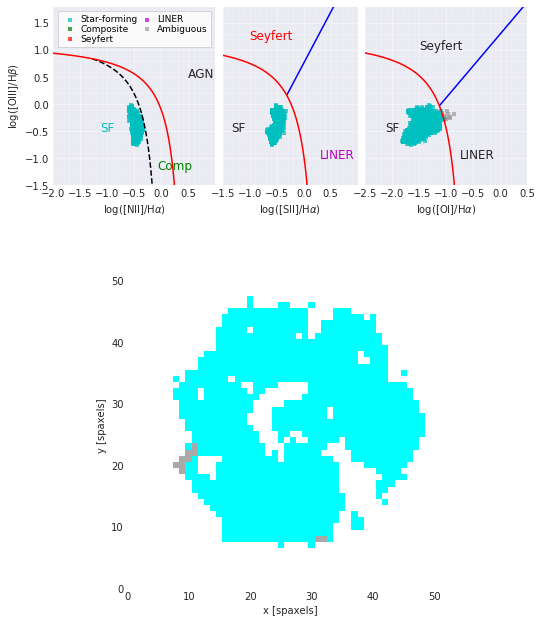

,bit,label,description
0,0,NOCOV,No coverage in this spaxel
1,1,LOWCOV,Low coverage in this spaxel
2,2,DEADFIBER,Major contributing fiber is dead
3,3,FORESTAR,Foreground star
4,4,NOVALUE,Spaxel was not fit because it did not meet sel...
5,5,UNRELIABLE,Value is deemed unreliable; see TRM for defini...
6,6,MATHERROR,Mathematical error in computing value
7,7,FITFAILED,Attempted fit for property failed
8,8,NEARBOUND,Fitted value is too near an imposed boundary; ...
9,9,NOCORRECTION,Appropriate correction not available


In [42]:
masks_bpt, __, __ = maps.get_bpt()
masks_bpt['sf']['global']
n2.pixmask.schema

In [43]:
mask_non_sf = ~masks_bpt['sf']['global'] * n2.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
mask = mask_non_sf | mask_bad_data

In [52]:
print(np.max(mask))
print(np.min(mask))
print(mask[np.where(mask[:,30]<10),0].shape)

1073741825
0
(1, 35)


In [53]:
mask[22:25,3:8]

array([[1073741825, 1073741824, 1073741824, 1073741824, 1073741824],
       [1073741824, 1073741824, 1073741824, 1073741824, 1073741824],
       [1073741824, 1073741824, 1073741824, 1073741824, 1073741824]])

/root/anaconda3/lib/python3.7/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True


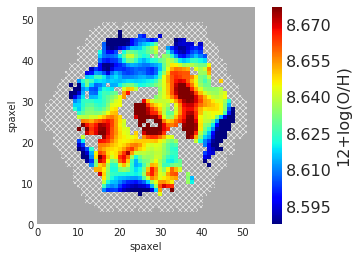

In [18]:
fig, ax = oh.plot(cmap='jet',mask=mask, cblabel='12+log(O/H)')

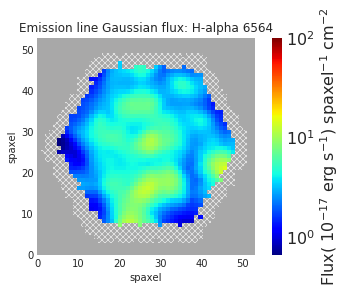

In [9]:
fig, ax, cb=ha.plot(cmap='jet',cblabel='Flux( $10^{-17}$ erg s$^{-1}$) spaxel$^{-1}$ cm$^{-2}$',log_cb=True,cbrange=(0.1,100),return_cb=True)
cb.set_ticks([0., 0.1, 1, 10, 100])
cb.set_ticklabels(['$10^{-2}$','$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'])

### 金属丰度和表面质量密度关系

In [101]:
import pandas as pd

In [102]:
import marvin

INFO: No release version set. Setting default to DR15


In [21]:
marvin.tools?

In [11]:
path_data

'/root/cosmos/galaxies-mzr/data'

In [106]:
#使用pandas读取csv文件中的质量
import pandas as pd
mstar = pd.read_csv(join(path_data, 'manga-{}_mstar.csv'.format(maps.plateifu)))

#mstar = pd.read_csv(join(path_data, 'sqlMastar-goodstars-v2_4_3.csv'))


AttributeError: 'numpy.ndarray' object has no attribute 'plateifu'

NameError: name 'mstar' is not defined

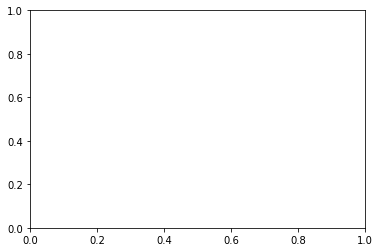

In [100]:
#计算画出表面质量密度
fig, ax = plt.subplots()
p = ax.imshow(mstar, origin='lower')
ax.set_xlabel('spaxel')
ax.set_ylabel('spaxel')
cb = fig.colorbar(p)
cb.set_label('log(Mstar) [M$_\odot$]')

In [15]:
#计算像素实际大小
spaxel_size = 0.5  # [arcsec]
redshift = maps.nsa['z']
c = 299792  # speed of light [km/s]
H0 = 70  # [km s^-1 Mpc^-1]
D = c * redshift / H0  # approx. distance to galaxy [Mpc]
scale = 1 / 206265 * D * 1e6  # 1 radian = 206265 arcsec [pc / arcsec]
spaxel_area = (scale * spaxel_size)**2  # [pc^2]

[0, 4, 8.0, 8.8]

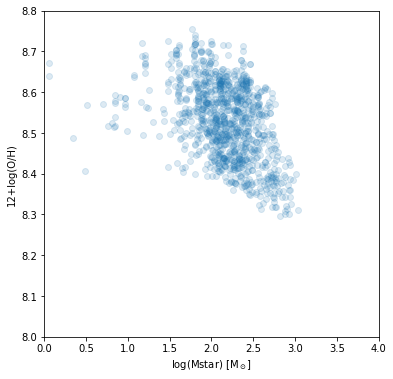

In [16]:
#计算质量密度
sigma_star = np.log10(10**mstar / spaxel_area)  # [Msun / pc^2]
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(sigma_star.values[mask == 0], oh.value[mask == 0], alpha=0.15)
ax.set_xlabel('log(Mstar) [M$_\odot$]')
ax.set_ylabel('12+log(O/H)')
ax.axis([0, 4, 8.0, 8.8])

In [17]:
maps.plateifu

'8077-6104'

### 使用一般方式导入读取fits文件数据

In [1]:
from astropy.io import fits
data1 = fits.getdata('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits',header=True)
data2 = fits.getdata('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_1_2-STELLARPOP.fits',header=True)

In [4]:
data1[1]


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  138 / length of dimension 1                          
NAXIS2  =                 4675 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'MANGAID '                                                            
TFORM1  = '20A     '                                                            
TTYPE2  = 'PLATEIFU'                                                            
TFORM2  = '20A     '                                                            
TTYPE3  = 'PLATE   '        

In [5]:
data2[1]

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  138 / length of dimension 1                          
NAXIS2  =                 2777 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'MANGAID '                                                            
TFORM1  = '20A     '                                                            
TTYPE2  = 'PLATEIFU'                                                            
TFORM2  = '20A     '                                                            
TTYPE3  = 'PLATE   '        

In [21]:
data1[0].choose?

Object `choose` not found.


In [5]:
data1[0].choose

NameError: name 'data1' is not defined

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
lalala = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits')
lala=fits.getdata('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits',header=True)
data2 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_1_2-STELLARPOP.fits')

In [4]:
data2.info()

Filename: /root/cosmos/galaxies-mzr/data/manga_firefly-v2_1_2-STELLARPOP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GALAXY_INFO    1 BinTableHDU     31   2777R x 11C   [20A, 20A, INT16, 20A, E, E, E, E, 20A, 20A, 20A]   
  2  GLOBAL_PARAMETERS    1 BinTableHDU     41   2777R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  3  GRADIENT_PARAMETERS    1 BinTableHDU     41   2777R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  SPATIAL_INFO    1 ImageHDU         9   (4, 2800, 2777)   float32   
  5  SPAXEL_BINID    1 ImageHDU        10   (6, 100, 100, 2777)   float64   
  6  LW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 2777)   float32   
  7  MW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 2777)   float32   
  8  LW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 2777)   float32   
  9  MW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 2777)   float32   
 10  E(B_V)_VORONOI  

In [8]:
sm = lalala[1].data['PHOTOMETRIC_MASS']
print(sm)

[1.40308e+09 4.32497e+10 6.19020e+09 ... 4.59672e+09 1.08103e+11
 1.60425e+09]


In [126]:
sm.shape

(4675,)

In [122]:
lalala[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  138 / length of dimension 1                          
NAXIS2  =                 4675 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'MANGAID '                                                            
TFORM1  = '20A     '                                                            
TTYPE2  = 'PLATEIFU'                                                            
TFORM2  = '20A     '                                                            
TTYPE3  = 'PLATE   '        

In [52]:
lala[1]

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  138 / length of dimension 1                          
NAXIS2  =                 4675 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
TTYPE1  = 'MANGAID '                                                            
TFORM1  = '20A     '                                                            
TTYPE2  = 'PLATEIFU'                                                            
TFORM2  = '20A     '                                                            
TTYPE3  = 'PLATE   '        

In [67]:
lalala.info()

Filename: /root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GALAXY_INFO    1 BinTableHDU     31   4675R x 11C   [20A, 20A, I, 20A, E, E, E, E, 20A, 20A, 20A]   
  2  GLOBAL_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  3  GRADIENT_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  SPATIAL_INFO    1 ImageHDU         9   (4, 2800, 4675)   float32   
  5  SPATIAL_BINID    1 ImageHDU         9   (76, 76, 4675)   int16   
  6  LW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  7  MW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  8  LW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  9  MW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
 10  E(B_V)_VORONOI    1 ImageH

In [79]:
plot1=lalala[11].data[1]
plot2=lalala[11].data[2]

In [116]:
type(lalala[11].data[2])

numpy.ndarray

In [117]:
np.shape(plot1)

(2800, 2)

In [118]:
plot1

array([[ 8.8200140e+00,  6.5209389e-02],
       [ 8.6450930e+00,  1.9699287e-01],
       [ 8.7641287e+00,  7.0210457e-02],
       ...,
       [-9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03]], dtype=float32)

In [77]:
nii

<Marvin Map (property='emline_gflux_nii_6585')>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 1e-17 erg / (cm2 s spaxel)

In [81]:
plt.imshow?

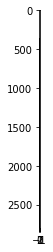

In [72]:
plt.imshow(plot1, cmap= 'gray');
#plt.colorbar();
plt.show();

### 从Marvin获取stellar mass数据及surface mass density

In [83]:
from __future__ import print_function, division, absolute_import

In [86]:
from marvin import config
config.setRelease('DR15')

In [1]:
from marvin.tools.query import Query

INFO: No release version set. Setting default to DR15


In [2]:
# 最简单的查询
myquery1 = 'nsa.sersic_mass > 3e11'
q1 = Query(search_filter=myquery1)
r1 = q1.run()
r1.results

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/query.py:236: MarvinUserWarning: No local database found. Cannot perform queries.
  warnings.warn('No local database found. Cannot perform queries.', MarvinUserWarning)


<ResultSet(set=1.0/1, index=0:22, count_in_set=22, total=22)>
[ResultRow(mangaid='1-134760', plateifu='8555-12701', sersic_mass=561190000000.0),
 ResultRow(mangaid='1-134760', plateifu='8600-9102', sersic_mass=561190000000.0),
 ResultRow(mangaid='1-146420', plateifu='8938-3704', sersic_mass=440193000000.0),
 ResultRow(mangaid='1-176803', plateifu='8613-12705', sersic_mass=498718000000.0),
 ResultRow(mangaid='1-177135', plateifu='8613-6102', sersic_mass=339921000000.0),
 ResultRow(mangaid='1-180153', plateifu='8616-12703', sersic_mass=366874000000.0),
 ResultRow(mangaid='1-217041', plateifu='8247-9102', sersic_mass=328593000000.0),
 ResultRow(mangaid='1-254532', plateifu='8454-1902', sersic_mass=1355340000000.0),
 ResultRow(mangaid='1-256301', plateifu='8258-9102', sersic_mass=7116800000000.0),
 ResultRow(mangaid='1-265907', plateifu='8333-12702', sersic_mass=711371000000.0),
 ResultRow(mangaid='1-278075', plateifu='8257-6104', sersic_mass=369127000000.0),
 ResultRow(mangaid='1-283711',

In [93]:
# 两个条件限定查询
myquery2 = 'nsa.sersic_mass > 3e11 AND nsa.z < 0.1'
q2 = Query(search_filter=myquery2)
r2 = q2.run()
r2.results

<ResultSet(set=1.0/1, index=0:7, count_in_set=7, total=7)>
[ResultRow(mangaid='1-176803', plateifu='8613-12705', sersic_mass=498718000000.0, z=0.0992977),
 ResultRow(mangaid='1-177135', plateifu='8613-6102', sersic_mass=339921000000.0, z=0.0863756),
 ResultRow(mangaid='1-256301', plateifu='8258-9102', sersic_mass=7116800000000.0, z=0.0961407),
 ResultRow(mangaid='1-283711', plateifu='8317-1901', sersic_mass=2579810000000.0, z=0.094444),
 ResultRow(mangaid='1-314409', plateifu='9024-12705', sersic_mass=506441000000.0, z=0.0601609),
 ResultRow(mangaid='1-338090', plateifu='8131-3701', sersic_mass=1150580000000.0, z=0.0806724),
 ResultRow(mangaid='1-377378', plateifu='8132-6102', sersic_mass=513575000000.0, z=0.0265521)]

In [94]:
# 复合搜索
myquery3 = '(nsa.sersic_mass > 3e11 AND nsa.z < 0.1) OR (ifu.name=127* AND nsa.elpetro_ba >= 0.95)'
q3 = Query(search_filter=myquery3)
r3 = q3.run()
r3.results

<ResultSet(set=1.0/1, index=0:36, count_in_set=36, total=36)>
[ResultRow(mangaid='1-145922', plateifu='8149-12704', sersic_mass=42171500000.0, elpetro_ba=0.986297, ifudesign_name='12704', z=0.026607),
 ResultRow(mangaid='1-149507', plateifu='8997-12705', sersic_mass=28400300000.0, elpetro_ba=0.953317, ifudesign_name='12705', z=0.0322763),
 ResultRow(mangaid='1-176803', plateifu='8613-12705', sersic_mass=498718000000.0, elpetro_ba=0.789834, ifudesign_name='12705', z=0.0992977),
 ResultRow(mangaid='1-177135', plateifu='8613-6102', sersic_mass=339921000000.0, elpetro_ba=0.94393, ifudesign_name='6102', z=0.0863756),
 ResultRow(mangaid='1-197186', plateifu='9864-12701', sersic_mass=119911000000.0, elpetro_ba=0.970726, ifudesign_name='12701', z=0.074555),
 ResultRow(mangaid='1-198212', plateifu='9034-12704', sersic_mass=87799700000.0, elpetro_ba=0.976644, ifudesign_name='12704', z=0.037839),
 ResultRow(mangaid='1-210881', plateifu='8604-12701', sersic_mass=113843000000.0, elpetro_ba=0.980852

In [100]:
# 查询可以用的参数有哪些
q = Query()
q.get_available_params()

[<ParameterGroup name=Metadata, n_parameters=7>,
 <ParameterGroup name=NSA Catalog, n_parameters=11>]

In [107]:
# 好像是？？？输出csv文件
q.datamodel.write_csv?

In [113]:
Query?

In [96]:
# 通过一定条件限定，返回相应的其他参数的值
myquery5 = 'nsa.z > 0.1'
bonusparams5 = ['cube.ra', 'cube.dec']
# bonusparams5 = 'cube.ra'  # This works too

q5 = Query(search_filter=myquery5, return_params=bonusparams5)
r5 = q5.run()

In [98]:
r5.results

<ResultSet(set=1.0/1, index=0:332, count_in_set=332, total=332)>
[ResultRow(mangaid='1-109308', plateifu='8082-12704', ra=49.9495621925, dec=-0.22114540619, z=0.131681),
 ResultRow(mangaid='1-109419', plateifu='8085-3702', ra=51.22895826, dec=0.605956492656, z=0.103253),
 ResultRow(mangaid='1-109493', plateifu='8156-9101', ra=56.4251416467, dec=-0.378460418812, z=0.10932),
 ResultRow(mangaid='1-113292', plateifu='7972-9101', ra=316.043643235, dec=8.99511499267, z=0.102271),
 ResultRow(mangaid='1-113468', plateifu='7815-3701', ra=317.918280237, dec=9.34565198917, z=0.136342),
 ResultRow(mangaid='1-113476', plateifu='8618-12705', ra=317.568825378, dec=10.4088108392, z=0.118158),
 ResultRow(mangaid='1-113521', plateifu='7815-6103', ra=317.388736588, dec=11.5029226993, z=0.135043),
 ResultRow(mangaid='1-113668', plateifu='7815-6102', ra=318.827736002, dec=10.4968107833, z=0.129233),
 ResultRow(mangaid='1-113675', plateifu='8618-3702', ra=318.775640877, dec=10.0984558649, z=0.129881),
 Resu

In [127]:
# 使用Marvin中的convertToTool. convertToTool来转换数据为fits格式或者csv格式等
from marvin.tools.query import Query
q = Query(search_filter='nsa.z < 0.1', return_params=['absmag_g_r'])
r = q.run()

# number of results
r.totalcount

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/query.py:236: MarvinUserWarning: No local database found. Cannot perform queries.
  warnings.warn('No local database found. Cannot perform queries.', MarvinUserWarning)


4275

In [136]:
q.run().results

<ResultSet(set=1.0/43, index=0:100, count_in_set=100, total=4275)>
[ResultRow(mangaid='1-109056', plateifu='8077-6103', elpetro_absmag_g_r=1.11703872680664, z=0.0473019),
 ResultRow(mangaid='1-109073', plateifu='8078-12704', elpetro_absmag_g_r=1.05978775024414, z=0.0435882),
 ResultRow(mangaid='1-109081', plateifu='8077-12705', elpetro_absmag_g_r=1.23031806945801, z=0.0438592),
 ResultRow(mangaid='1-109112', plateifu='8078-1901', elpetro_absmag_g_r=1.5319881439209, z=0.0249702),
 ResultRow(mangaid='1-109152', plateifu='8154-12702', elpetro_absmag_g_r=1.5439453125, z=0.0281736),
 ResultRow(mangaid='1-109167', plateifu='8078-1902', elpetro_absmag_g_r=1.65657424926758, z=0.0246344),
 ResultRow(mangaid='1-109234', plateifu='9193-1901', elpetro_absmag_g_r=1.52570343017578, z=0.0409309),
 ResultRow(mangaid='1-109244', plateifu='8080-12702', elpetro_absmag_g_r=1.52271270751953, z=0.0267911),
 ResultRow(mangaid='1-109250', plateifu='8080-1902', elpetro_absmag_g_r=0.780342102050781, z=0.0383731

In [ ]:
# view the results
r.results

In [ ]:
r.datamodel
<QueryDataModel release='MPL-4', n_groups=7, n_parameters=565, n_total=0>

In [ ]:
r = q.run()
r.results

In [ ]:
# convert results to Marvin Cube tools
r.convertToTool('cube')
r.objects

In [ ]:
To Pandas Dataframe
r.toDF()  # r.toDataFrame()

In [ ]:
To Astropy Tables
r.toTable()

In [ ]:
To FITS
r.toFits(filename='myresults.fits')

In [137]:
#To CSV
r.toCSV(filename='myresults.csv')

Writing new CSV file myresults.csv


In [2]:
from pyds9 import *
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import copy as copy
lalala0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits')
lalala=copy.copy(lalala0)
lala=fits.getdata('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits',header=True)
# 调用pyds9.DS9
d=pyds9.DS9

In [12]:
lalala[1].header
lalala.info()
lalala[11].data[1]

Filename: /root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GALAXY_INFO    1 BinTableHDU     31   4675R x 11C   [20A, 20A, I, 20A, E, E, E, E, 20A, 20A, 20A]   
  2  GLOBAL_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  3  GRADIENT_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  SPATIAL_INFO    1 ImageHDU         9   (4, 2800, 4675)   float32   
  5  SPATIAL_BINID    1 ImageHDU         9   (76, 76, 4675)   int16   
  6  LW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  7  MW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  8  LW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  9  MW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
 10  E(B_V)_VORONOI    1 ImageH

array([[ 8.8200140e+00,  6.5209389e-02],
       [ 8.6450930e+00,  1.9699287e-01],
       [ 8.7641287e+00,  7.0210457e-02],
       ...,
       [-9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03]], dtype=float32)

In [11]:
lalala = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits')

In [10]:
lalala.info()

Filename: /root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GALAXY_INFO    1 BinTableHDU     31   4675R x 11C   [20A, 20A, I, 20A, E, E, E, E, 20A, 20A, 20A]   
  2  GLOBAL_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  3  GRADIENT_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  SPATIAL_INFO    1 ImageHDU         9   (4, 2800, 4675)   float32   
  5  SPATIAL_BINID    1 ImageHDU         9   (76, 76, 4675)   int16   
  6  LW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  7  MW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  8  LW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  9  MW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
 10  E(B_V)_VORONOI    1 ImageH

In [28]:
la_mass=lalala[11].data[785][0]
la_space=lalala[4].data[5][0][1]
print('质量信息:\n',la_mass,'\n\n\n','坐标信息:\n',la_space)

质量信息:
 [7.0619     0.16655016] 


 坐标信息:
 -0.0067892107


In [6]:
type(lalala[11].data[1])

numpy.ndarray

In [4]:
type(lalala[4].data[4674,:,1])

numpy.ndarray

In [36]:
la_test_mass=lalala[13].data[4674,1,:]
print(np.shape(la_test_mass))
print(la_test_mass)

(2,)
[8.249257   0.17722225]


In [26]:
lalala7=lalala[4].data[4674,1,:]
lalala7


array([ 3.0000000e+00, -4.9445590e-01,  1.5865494e-03,  7.4015744e-02],
      dtype=float32)

In [7]:
from scipy import stats
la1=lalala[11].data[1]
xx, yy = np.meshgrid(la1, la1)


In [15]:
# 使用numpy生成一个nan的数组
np.full([1,5], np.nan)

array([[nan, nan, nan, nan, nan]])

In [31]:
import copy
la2=copy.copy(la1)
la2 += 0.01

### 尝试用一个星系画出其质量分布图

In [62]:
#lalala_mass=np.zeros([2800,2],dtype=float)
print(lalala_mass)

-9999.0


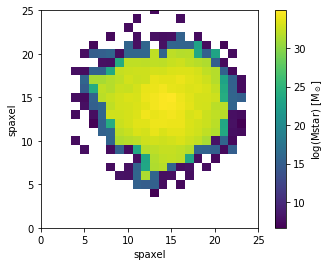

In [2]:
################################################
# 画出编号为'8077-6104'，数组位置为249的星系的surface mass density
# 使用粗略的四舍五入进行分bin操作画图
################################################

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import copy as copy

# 读取fits文件
lalala0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits')
lala=fits.getdata('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits',header=True)
lalala=copy.copy(lalala0)    # copy一下，去除只读属性
# plate_ifu 星系编号
plate_ifu_num = '8077-6104'

# 星系的数组位置【共4675个星系】
galaxy_arr_num = 249

# 表面质量密度
lalala_mass=np.zeros([2800,1],dtype=float)
lalala_mass[:,0]=lalala[13].data[galaxy_arr_num,:,0]

# 坐标信息
lalala_x_y=np.zeros([2800,2],dtype=float)
lalala_x_y[:,0]=lalala[4].data[galaxy_arr_num,:,1]
lalala_x_y[:,1]=lalala[4].data[galaxy_arr_num,:,2]

# 异常数据重置为0
# 异常数据 == -9999,且所有的异常数据在数组位置中都为-9999
lalala_mass[np.where(lalala_mass==-9999)]=0
lalala_x_y[np.where(lalala_x_y==-9999)]=0

# 平移缩放坐标
lalala_x_y+=15
lalala_x_y*=1

# 四舍五入
lalala_x_y=np.around(lalala_x_y)

# 生成目标画图数组
lalala_plot_mass_density=np.zeros([300,300],dtype=float)
for i in range(0,2800):
    ii=int(lalala_x_y[i,0])-1
    jj=int(lalala_x_y[i,1])-1
    lalala_plot_mass_density[ii,jj]+=lalala_mass[i]

# 画图
lalala_plot_mass_density[np.where(lalala_plot_mass_density==-0)]=np.nan
fig, ax = plt.subplots()
p = ax.imshow(lalala_plot_mass_density)
ax.set_xlabel('spaxel')
ax.set_ylabel('spaxel')
plt.xlim((0,25))    # x轴坐标范围
plt.ylim((0,25))    # y轴坐标范围
cb = fig.colorbar(p)
cb.set_label('log(Mstar) [M$_\odot$]')
cb.range=(5.5,8.5)


In [58]:
np.min(lalala_mass)

0.0

In [14]:
test=lalala[5].data
test[249,10:30,10:30]

array([[ -1,  -1,  -1,  -1,  -1, 756, 756, 756, 756, 751, 751, 758, 757,
        753, 752, 739, 750, 750, 717, 717],
       [ -1,  -1,  -1, 716, 716, 727, 727, 756, 756, 743, 751, 747, 746,
        741, 739, 739, 738, 714, 717, 717],
       [ -1,  -1,  -1, 716, 716, 716, 727, 727, 743, 743, 730, 724, 718,
        715, 711, 708, 710, 714, 693, 696],
       [ -1,  -1,  -1, 716, 716, 700, 712, 712, 692, 692, 702, 697, 695,
        691, 688, 685, 687, 690, 693, 696],
       [ -1,  -1, 694, 716, 716, 700, 712, 712, 692, 692, 684, 680, 674,
        668, 665, 663, 661, 664, 667, 672],
       [ -1,  -1, 694, 694, 694, 681, 675, 675, 682, 673, 662, 657, 648,
        644, 636, 633, 632, 634, 638, 643],
       [694, 694, 694, 694, 681, 681, 675, 675, 659, 651, 637, 627, 618,
        601, 596, 593, 594, 599, 603, 616],
       [ -1, 694, 694, 694, 681, 681, 666, 655, 635, 619, 592, 585, 575,
        569, 564, 562, 563, 566, 573, 579],
       [646, 646, 646, 646, 660, 660, 647, 626, 590, 574, 554, 5

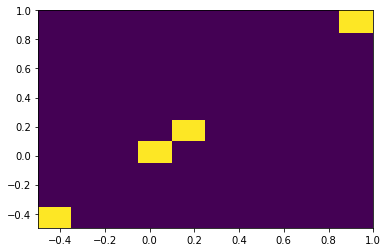

In [37]:
test=lalala[4].data
plt.hist2d(test[2,1,:],test[2,1,:])
plt.show()

In [23]:
# ################################################
# 画出编号为'8077-6104'，数组位置为249的星系的surface mass density
# 使用分bin操作重现Marvin网站示例图
################################################

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import copy as copy

# 读取fits文件
lalala0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits')
lala=fits.getdata('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits',header=True)
lalala=copy.copy(lalala0)    # copy一下，去除只读属性
# plate_ifu 星系编号
plate_ifu_num = '8077-6104'

# 星系的数组位置【共4675个星系】
galaxy_arr_num = 249

# 表面质量密度
lalala_mass=np.zeros([2800,1],dtype=float)
lalala_mass[:,0]=lalala[11].data[galaxy_arr_num,:,0]

# 坐标信息
lalala_x_y=np.zeros([2800,2],dtype=float)
lalala_x_y[:,0]=lalala[4].data[galaxy_arr_num,:,1]
lalala_x_y[:,1]=lalala[4].data[galaxy_arr_num,:,2]

# 异常数据重置为0
# 异常数据 == -9999,且所有的异常数据在数组位置中都为-9999
lalala_mass[np.where(lalala_mass==-9999)]=0
lalala_x_y[np.where(lalala_x_y==-9999)]=0

# 平移缩放坐标
lalala_x_y[np.where(lalala_x_y!=0)]+=15
lalala_x_y[np.where(lalala_x_y!=0)]*=1


In [24]:
np.min(lalala_x_y[:,0])

0.0

[ 0.          2.6000514   5.20010281  7.80015421 10.40020561 13.00025702
 15.60030842 18.20035982 20.80041122 23.40046263 26.00051403]
[ 0.          2.40000734  4.80001469  7.20002203  9.60002937 12.00003672
 14.40004406 16.8000514  19.20005875 21.60006609 24.00007343]


2.6000514030456543

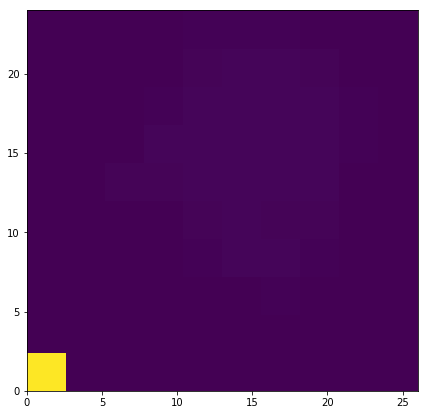

In [27]:
plt.figure(figsize=(7,7))
hist, xbins, ybins, cax = plt.hist2d(lalala_x_y[:,0],lalala_x_y[:,1],bins=(10,10));
print(xbins)
print(ybins)
xbins[1]

In [34]:
# 生成目标画图数组
plot_size = 30
plot_delta = 0.1    # 一就是默认分辨率
plot_mesh_size = int(plot_size/plot_delta)
lalala_plot_mass_density=np.zeros([plot_mesh_size,plot_mesh_size],dtype=float)
xx = lalala_x_y[:,0]
yy = lalala_x_y[:,1]
for ii in range(0,2800):
    for i in range(0,ybins.size-1):    # 先检索y方向
        if (lalala_x_y[ii,1]>=ybins[i]) & (lalala_x_y[ii,1]<ybins[i+1]):
            for j in range(0,xbins.size-1):    # 再检索x方向
                if (lalala_x_y[ii,0]>=xbins[j]) & (lalala_x_y[ii,0]<xbins[j+1]):
                    plot_x = int(i / (ybins.size) * (plot_size/plot_delta))
                    plot_y = int(j / (xbins.size) * (plot_size/plot_delta))
                    lalala_plot_mass_density[plot_x,plot_y] += lalala_mass[ii,0]
                

        

In [39]:
lalala_plot_mass_density[np.where(lalala_plot_mass_density!=0)]

array([  6.95756292,  13.02053738,  48.44445896,  92.69807816,
        35.32560301,  20.20006704,  13.78909588,  93.61393166,
       185.31004286, 182.11585665,  86.24430799,  20.52170753,
        36.16880274,  49.42043829, 147.69694996, 182.05509567,
       150.49332905, 147.01146603,  14.37503242,  13.59425592,
         6.05439186, 113.18422508, 144.13497639, 190.56240129,
       233.84904194, 192.66244316, 185.24033451,  50.56703043,
        49.49606562, 176.35332537, 191.35286045, 237.5599637 ,
       195.21956348, 186.09197283,  78.99895287,  14.28400946,
       100.93209934, 188.83206511, 230.61180401, 192.06030941,
       185.89467049,  77.91014242,   6.86451387,  48.43406153,
       145.2576232 , 222.55284929, 177.65558243, 128.60310793,
        34.28562832,  13.65456438,  56.51612282,  84.42494726,
        70.84806681,  20.36647892])

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import copy as copy

# 读取fits文件
lalala0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits')
lala=fits.getdata('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits',header=True)
lalala=copy.copy(lalala0)    # copy一下，去除只读属性
# plate_ifu 星系编号


# 星系的数组位置【共4675个星系】
galaxy_arr_num = 249

# 表面质量密度
lalala_mass=np.zeros([2800,1],dtype=float)
lalala_mass[:,0]=lalala[11].data[galaxy_arr_num,:,0]

# 坐标信息
lalala_x_y=np.zeros([2800,2],dtype=float)
lalala_x_y[:,0]=lalala[4].data[galaxy_arr_num,:,1]
lalala_x_y[:,1]=lalala[4].data[galaxy_arr_num,:,2]

# 异常数据重置为0
# 异常数据 == -9999,且所有的异常数据在数组位置中都为-9999
lalala_mass[np.where(lalala_mass==-9999)]=-2333
lalala_x_y[np.where(lalala_x_y==-9999)]=-2333

# 平移缩放坐标
lalala_x_y+=15
lalala_x_y*=10

# 四舍五入
#lalala_x_y=np.around(lalala_x_y)

# 生成目标画图数组
#lalala_plot_mass_density=np.zeros([300,300],dtype=float)
#for i in range(0,2800):
#    ii=int(lalala_x_y[i,0])-1
#    jj=int(lalala_x_y[i,1])-1
#    lalala_plot_mass_density[ii,jj]+=lalala_mass[i]



In [40]:
# 读取星系编号
plate_ifu0=lalala[1].data
plate_ifu=np.zeros((plate_ifu0.size,1))
plate_ifu=plate_ifu.astype(np.str)
#plate_ifu=plate_ifu0[0][1]
for i in range(0,plate_ifu0.size):
    plate_ifu[i,0]=plate_ifu0[i][1]
    #plate_ifu = np.char.add( plate_ifu, plate_ifu0[i][1] )
print( plate_ifu)

# 根据plateifu编号来寻找数组中的位置
plate_ifu_search = '8077-6104'
num_array = np.where(plate_ifu==plate_ifu_search)
print(num_array[0][0])

[['8252-12701']
 ['8979-12701']
 ['8933-6102']
 ...
 ['8084-3702']
 ['8082-12704']
 ['8485-12704']]
249


In [41]:
# 根据plateifu编号来寻找数组中的位置
plate_ifu_search = '8077-6104'
num_array = np.where(plate_ifu==plate_ifu_search)
print(num_array[0][0])

249


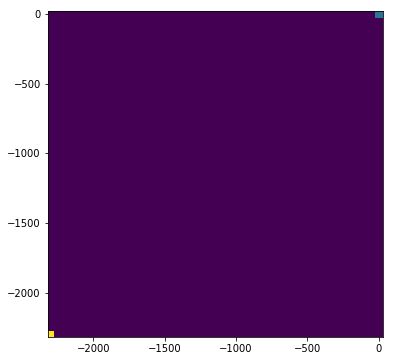

In [9]:
plt.figure(figsize=(6,6))
hist, xbins, ybins, cax = plt.hist2d(lalala_x_y[:,0],lalala_x_y[:,1],bins=(50,50));

In [10]:
xbins

array([-2318.        , -2271.11998972, -2224.23997944, -2177.35996916,
       -2130.47995888, -2083.5999486 , -2036.71993832, -1989.83992804,
       -1942.95991776, -1896.07990747, -1849.19989719, -1802.31988691,
       -1755.43987663, -1708.55986635, -1661.67985607, -1614.79984579,
       -1567.91983551, -1521.03982523, -1474.15981495, -1427.27980467,
       -1380.39979439, -1333.51978411, -1286.63977383, -1239.75976355,
       -1192.87975327, -1145.99974298, -1099.1197327 , -1052.23972242,
       -1005.35971214,  -958.47970186,  -911.59969158,  -864.7196813 ,
        -817.83967102,  -770.95966074,  -724.07965046,  -677.19964018,
        -630.3196299 ,  -583.43961962,  -536.55960934,  -489.67959906,
        -442.79958878,  -395.9195785 ,  -349.03956821,  -302.15955793,
        -255.27954765,  -208.39953737,  -161.51952709,  -114.63951681,
         -67.75950653,   -20.87949625,    26.00051403])

TypeError: Invalid dimensions for image data

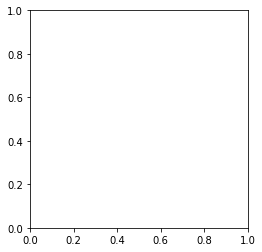

In [162]:
# 直接利用坐标数组和密度数组画图，不使用四舍五入
lalala_plot_mass_density=np.zeros([2800,3],dtype=float)
lalala_plot_mass_density[:,0] = lalala_x_y[:,0]
lalala_plot_mass_density[:,1] = lalala_x_y[:,1]
lalala_plot_mass_density[:,2] = lalala_mass[:,0]
xx = lalala_plot_mass_density[:,0]
yy = lalala_plot_mass_density[:,1]
z = lalala_plot_mass_density[:,2]
x, y = np.meshgrid(xx, yy)
plt.imshow(z, cmap='jet', origin='low')

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


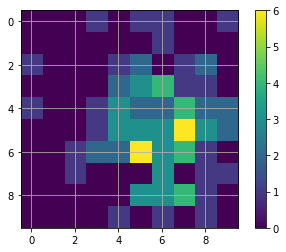

In [155]:
import numpy as np
from matplotlib import pyplot as plt 
# 高斯分布
mean = [0,0]
cov = [[0,1],[1,0]]
x, y = np.random.multivariate_normal(mean, cov, 100).T

 
hist, xedges, yedges = np.histogram2d(x,y)
X,Y = np.meshgrid(xedges,yedges)

plt.imshow(hist, interpolation='nearest')
plt.grid(True)
plt.colorbar()
plt.show()

In [154]:
x.size

10000

In [152]:
y

array([-0.55229954,  2.0505071 , -0.84151593, ..., -0.73836633,
       -0.36120048, -0.0985296 ])

In [11]:
lalala_plot_mass_density[np.where(lalala_plot_mass_density==-233)]=np.nan
fig, ax = plt.subplots()
p = ax.imshow(lalala_plot_mass_density)
ax.set_xlabel('spaxel')
ax.set_ylabel('spaxel')
plt.xlim((-500,250))
plt.ylim((-500,250))
cb = fig.colorbar(p)
#cb.set_label('log(Mstar) [M$_\odot$]')
cb.set_label('log(Mstar) [M$_\odot$]')

NameError: name 'lalala_plot_mass_density' is not defined

In [48]:
print(np.max(lalala_x_y))
print(np.min(lalala_x_y))

60.0
0.0


In [47]:
# 确认异常数据中，坐标x，y，质量密度是否一致-----> 已确认一致
te1_x=lalala[4].data[4674,:,1]
te1_y=lalala[4].data[4674,:,2]
te2=lalala[11].data[4674,:,0]
print(np.where(te1_x==-9999))
print(np.where(te1_y==-9999))
print(np.where(te2==-9999))
print(np.where(te1_x==te2))

(array([ 102,  103,  104, ..., 2797, 2798, 2799]),)
(array([ 102,  103,  104, ..., 2797, 2798, 2799]),)
(array([ 102,  103,  104, ..., 2797, 2798, 2799]),)
(array([ 102,  103,  104, ..., 2797, 2798, 2799]),)


In [49]:
# 找出数组中某一范围中的最大值最小值
te=lalala[4].data[4674,:,1]
num_max=1000
num_min=-9999
print(np.where((te<num_max)&(te>num_min)))
print(te[np.where((te<num_max)&(te>num_min))])
te_temp=te[np.where((te<num_max)&(te>num_min))]
te_min=np.min(te_temp)
te_max=np.max(te_temp)
print('\n最大值为 ',te_max,'\n','\n最小值为 ',te_min,'\n个数为 ',te_temp.shape)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),)
[ 5.5444990e-03 -4.9445590e-01  5.5444990e-03  5.5444990e-03
  5.0554490e-01 -4.9445453e-01 -4.9445727e-01  5.0554353e-01
  5.0554627e-01 -9.9445629e-01  5.5444990e-03  5.5444990e-03
  1.0055453e+00 -9.9445355e-01 -9.9445909e-01 -4.9445313e-01
 -4.9445868e-01  5.0554216e-01  5.0554764e-01  1.0055425e+00
  1.0055481e+00 -9.9445081e-01 -9.9446183e-01  1.0055398e+00
  1.0055509e+00 -1.4944568e+00  5.5444990e-03  5.5444990e-03
 -1

In [40]:
np.shape(te)

(2800,)

In [3]:
plot1 = stats.norm.pdf(xx) * stats.norm.pdf(yy)

In [4]:
d.get_arr2np(plot1)
# Zoom to fit
d.set('zoom to fit')
 
# Change the colormap and scaling
d.set('cmap bb')
d.set('scale log')
 
# Add a label
d.set('regions command {text 30 20 #text="Fun with pyds9" font="times 18 bold"}')

AttributeError: 'numpy.ndarray' object has no attribute '_selftest'

In [16]:
la1=lalala[11].data[1]
d.get_arr2np(la1)

AttributeError: 'numpy.ndarray' object has no attribute '_selftest'

### 使用提供的脚本

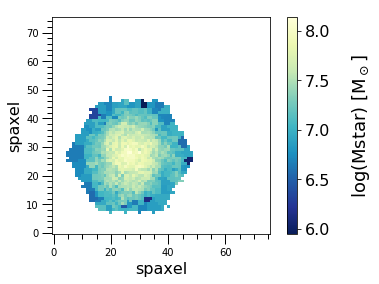

In [99]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits

#read in the vac file
vac = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 

#plate and ifu ID of the galaxy
plate = 8077
ifu = 6104

#choose the quantity to make the map, could be changed to other properties for which the extension names are listed in the data model  
prop = 'STELLAR_MASS_VORONOI'    # property 特性
#SURFACE_MASS_DENSITY_VORONOI

binid = vac[5].data
basic = vac[1].data
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID
mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据
bin1d = vac[4].data[galid,:,0][0]    # 获取一维的bin数据
image_sz = 76
maps = np.zeros((image_sz,image_sz))-99    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

#only show the spaxels with non-empty values
masked_array = np.ma.array(maps,mask=(maps<-10))

#colour scheme for the colour bar
cmap = matplotlib.cm.jet
#cmap.set_bad('white',1.)

#plot the map 
f = plt.imshow(masked_array,interpolation='nearest',cmap='YlGnBu_r',origin='lower')

plt.minorticks_on()
plt.tick_params(length=10, width=1, which='major')
plt.tick_params(length=5, width=1, which='minor')
#plt.xlabel(r"X-offset $('')$",fontsize=24)
#plt.ylabel(r"Y-offset $('')$",fontsize=24)
plt.xlabel(r"spaxel",fontsize=16)
plt.ylabel(r"spaxel",fontsize=16)
#plot the colour bar
cbar = plt.colorbar(f,fraction=0.15,shrink=1.0)
cbar.set_label('log(Mstar) [M$_\odot$]',fontsize=18, rotation=90, labelpad=20)
cbar.ax.tick_params(labelsize=16)

#plt.tight_layout()
plt.show()



/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits' mode='rb' closefd=True>
  import sys
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:166: RuntimeWarning: divide by zero encountered in log10
  value=ufunc(self.value),


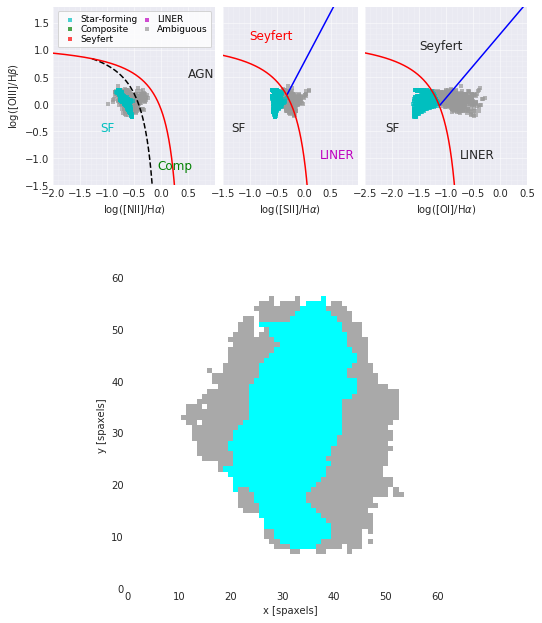

MaskError: Mask and data not compatible: data size is 2916, mask size is 4096.

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

#read in the vac file
vac = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 

#plate and ifu ID of the galaxy
plate = 8252
ifu = 9102

#choose the quantity to make the map, could be changed to other properties for which the extension names are listed in the data model  
prop = 'STELLAR_MASS_VORONOI'    # property 特性
#SURFACE_MASS_DENSITY_VORONOI

binid = vac[5].data
basic = vac[1].data
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID
mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据
bin1d = vac[4].data[galid,:,0][0]    # 获取一维的bin数据

# 导入Marvin的mask
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

new_maps = Maps('8252-9102')
nii = new_maps.emline_gflux_nii_6585
ha = new_maps.emline_gflux_ha_6564
n2 = nii / ha
logn2 = np.log10(n2)
oh =  0.57 * logn2+8.90 
masks_bpt, __, __ = new_maps.get_bpt()
masks_bpt['sf']['global']
n2.pixmask.schema
mask_non_sf = ~masks_bpt['sf']['global'] * n2.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr

# 画图
image_sz = 76    # 图像边长
maps = np.zeros((image_sz,image_sz))-99    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

#only show the spaxels with non-empty values
maps = maps[0:54,0:54]
masked_array = np.ma.array(maps,mask=new_mask)

fig, ax = plt.subplots()
p = ax.imshow(masked_array , origin='lower',vmin=5.5,vmax=8.5)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
cb.set_label('surface mass density ',fontsize=18,labelpad=10)
plt.xlim((0,53))    # x轴坐标范围
plt.ylim((0,53))    # y轴坐标范围

cb.range=(10,30)

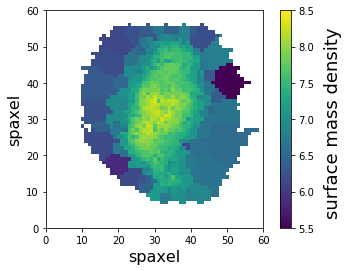

In [6]:
# 画图
image_sz = 76    # 图像边长
maps = np.zeros((image_sz,image_sz))-99    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

#only show the spaxels with non-empty values
masked_array = np.ma.array(maps,mask=(maps<-10))

fig, ax = plt.subplots()
#p = ax.imshow(masked_array , origin='lower',vmin=6.0,vmax=8.9,norm=mpl.colors.LogNorm())
p = ax.imshow(masked_array , origin='lower',vmin=5.5,vmax=8.5)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
cb.set_label('surface mass density ',fontsize=18,labelpad=10)
plt.xlim((0,60))    # x轴坐标范围
plt.ylim((0,60))    # y轴坐标范围

cb.range=(10,30)
#cb.set_ticks([5.5, 6.0, 6.5, 7.0, 7.5,8.0,8.5])
#cb.set_ticklabels(['5.5','6.0', '6.5', '7.0', '7.5', '8.0', '8.5'])

In [29]:
np.shape(maps<-10)

(76, 76)

In [36]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

new_maps = Maps('8077-6104')
nii = new_maps.emline_gflux_nii_6585
ha = new_maps.emline_gflux_ha_6564
n2 = nii / ha
logn2 = np.log10(n2)
oh =  0.57 * logn2+8.90 
masks_bpt, __, __ = new_maps.get_bpt()
masks_bpt['sf']['global']
n2.pixmask.schema
mask_non_sf = ~masks_bpt['sf']['global'] * n2.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value


In [38]:
maps.get_bpt?

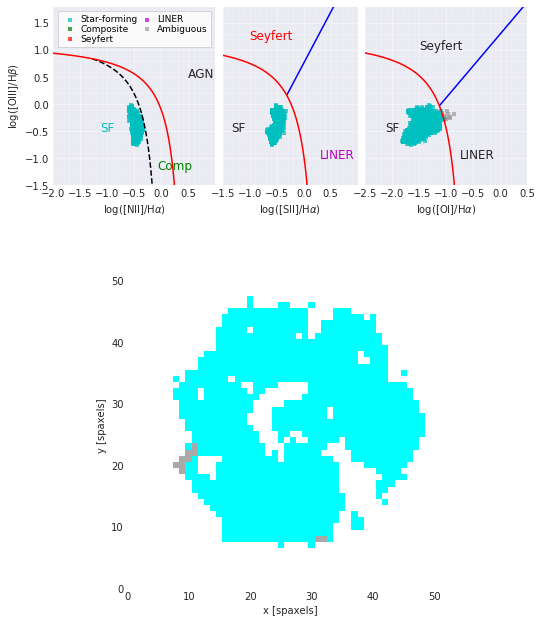

In [43]:
masks_bpt, __, __ = maps.get_bpt()
masks_bpt['sf']['global']
n2.pixmask.schema
mask_non_sf = ~masks_bpt['sf']['global'] * n2.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr

In [44]:
np.shape(new_mask)

(54, 54)

In [74]:
len(test[test1])

1

> - ###  做出一个星系的 metallicity and stellar surface mass density
> - ###  筛选星系
>> - ###  做出筛选出的星系的所有的 metallicity and stellar surface mass density
> - ###  根据stellar mass 分组，分别作出 每一组的 metallicity 分布
>> - ###  找出每个的peak，然后重叠在原图中，即可完全复原论文的图

In [1]:
import math
math.pi

3.141592653589793